In [1]:
from models import model3dfcnn
from constants import globals as g
# import os

import numpy as np
import cv2 
import time
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf

from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


In [2]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

# No GPU found

No GPU found


In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
SEQUENCE_LENGTH = 10

DATASET_DIR = "../../data/heatmap/raw"
# CLASSES_LIST = os.listdir(DATASET_DIR)
# NUM_CLASSES = len(CLASSES_LIST)

In [4]:
def frames_from_video_file(path, max_frames=10, resize=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    """ Process video by extracting individual frames and
        converting them to numpy array

        Args:
            path: Source path of the video
            max_frames: Maximum number of frames to be extracted
            resize (default=(64,64)): Size of frame to be resize into

        Returns:
            Numpy array of frames with normalized pixel values
    """

    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            if len(frames) == max_frames:
                break

    finally:
        cap.release()
    return np.array(frames) / 255.0

In [5]:
import re
from tqdm import tqdm

CLASSES_LIST = ['gallop', 'hop', 'jump', 'leap', 'run', 'skip', 'slide']

def create_dataset():
    """
    This function will extract the data from videos in the dataset directory and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    """
    features = []
    labels = []
    video_files_paths = []

    # Define a pattern to extract class labels from filenames
    pattern = re.compile(r'_(gallop|hop|jump|leap|run|skip|slide)_')

    # Get the list of all video files in the dataset directory
    files_list = os.listdir(DATASET_DIR)

    for file_name in tqdm(files_list, total=len(files_list), desc="Creating dataset"):
        if file_name.endswith(".mp4"):
            # Get the complete video path
            video_file_path = os.path.join(DATASET_DIR, file_name)

            # Extract the class label from the filename
            match = pattern.search(file_name)
            if match:
                class_name = match.group(1)
                class_index = CLASSES_LIST.index(class_name)

                # Extract the frames of the video file
                frames = frames_from_video_file(video_file_path,
                                                max_frames=SEQUENCE_LENGTH,
                                                resize=(IMAGE_HEIGHT, IMAGE_WIDTH))

                # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified
                if len(frames) == SEQUENCE_LENGTH:
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [6]:
X, y, filepaths = create_dataset()

Creating dataset: 100%|██████████| 307/307 [00:04<00:00, 70.47it/s]


In [7]:
X.shape

(305, 10, 128, 128, 3)

In [8]:
# Apply one-hot encoding to labels
y_encoded = to_categorical(y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded,
                                                    test_size = 0.2,
                                                    stratify=y_encoded,
                                                    random_state = 42)

In [10]:
print(f"Train len: {len(X_train)}")
print(f"Test len: {len(X_test)}")

Train len: 244
Test len: 61


In [11]:
model_params = {
    "input_shape": (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3),
    "num_classes": 7,
    "model_name": "3DFCNNv1",
    "to_print": False
}

model = model3dfcnn.buildModel(**model_params)
model.summary()

Model: "3DFCNNv1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 128, 128, 3)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 10, 128, 128, 32)  2624      
                                                                 
 batch_normalization (BatchN  (None, 10, 128, 128, 32)  128      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 10, 128, 128, 32)  0         
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 128, 128, 32)  27680     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 128, 128, 32)  12

In [12]:
model_checkpoint = ModelCheckpoint(
    filepath="../../results/3DFCNN",
    save_best_only=True,
    verbose=0,
    save_weights_only=False,
)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=3, min_lr=1e-4,)

callbacks = [model_checkpoint, reduceLR]

start_train_time = time.time()
history = model.fit(
    X_train, y_train, epochs=20, callbacks=callbacks, validation_data=(X_test, y_test), batch_size=4
)
end_train_time = time.time()

Epoch 1/20
61/61 [==============================] - ETA: 0s - loss: 2.2216 - accuracy: 0.2131

INFO:tensorflow:Assets written to: ../../results\3DFCNN\assets


INFO:tensorflow:Assets written to: ../../results\3DFCNN\assets


61/61 [==============================] - 187s 3s/step - loss: 2.2216 - accuracy: 0.2131 - val_loss: 1.8400 - val_accuracy: 0.2951 - lr: 0.0010
Epoch 2/20
61/61 [==============================] - 183s 3s/step - loss: 1.7495 - accuracy: 0.3361 - val_loss: 1.9032 - val_accuracy: 0.2951 - lr: 0.0010
Epoch 3/20
61/61 [==============================] - 184s 3s/step - loss: 1.6002 - accuracy: 0.3402 - val_loss: 2.0160 - val_accuracy: 0.1148 - lr: 0.0010
Epoch 4/20
61/61 [==============================] - ETA: 0s - loss: 1.5150 - accuracy: 0.3811

INFO:tensorflow:Assets written to: ../../results\3DFCNN\assets


INFO:tensorflow:Assets written to: ../../results\3DFCNN\assets


61/61 [==============================] - 185s 3s/step - loss: 1.5150 - accuracy: 0.3811 - val_loss: 1.7245 - val_accuracy: 0.3443 - lr: 0.0010
Epoch 5/20
61/61 [==============================] - ETA: 0s - loss: 1.4741 - accuracy: 0.4508

INFO:tensorflow:Assets written to: ../../results\3DFCNN\assets


INFO:tensorflow:Assets written to: ../../results\3DFCNN\assets


61/61 [==============================] - 185s 3s/step - loss: 1.4741 - accuracy: 0.4508 - val_loss: 1.6130 - val_accuracy: 0.4098 - lr: 0.0010
Epoch 6/20
61/61 [==============================] - ETA: 0s - loss: 1.2587 - accuracy: 0.5082

INFO:tensorflow:Assets written to: ../../results\3DFCNN\assets


INFO:tensorflow:Assets written to: ../../results\3DFCNN\assets


61/61 [==============================] - 186s 3s/step - loss: 1.2587 - accuracy: 0.5082 - val_loss: 1.5017 - val_accuracy: 0.3770 - lr: 0.0010
Epoch 7/20
61/61 [==============================] - 183s 3s/step - loss: 1.0985 - accuracy: 0.5820 - val_loss: 1.9673 - val_accuracy: 0.3115 - lr: 0.0010
Epoch 8/20
61/61 [==============================] - 183s 3s/step - loss: 0.8929 - accuracy: 0.6680 - val_loss: 1.6976 - val_accuracy: 0.4754 - lr: 0.0010
Epoch 9/20
61/61 [==============================] - 183s 3s/step - loss: 0.6730 - accuracy: 0.7746 - val_loss: 2.1827 - val_accuracy: 0.4262 - lr: 0.0010
Epoch 10/20
61/61 [==============================] - 183s 3s/step - loss: 0.4737 - accuracy: 0.8361 - val_loss: 1.9257 - val_accuracy: 0.4426 - lr: 1.0000e-04
Epoch 11/20
61/61 [==============================] - 183s 3s/step - loss: 0.3591 - accuracy: 0.9016 - val_loss: 1.8221 - val_accuracy: 0.4754 - lr: 1.0000e-04
Epoch 12/20
61/61 [==============================] - 183s 3s/step - loss: 0.2

In [13]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 4s 2s/step - loss: 2.4560 - accuracy: 0.5082


[2.4560441970825195, 0.5081967115402222]

In [15]:
training_elapsed = end_train_time - start_train_time

print(f"Elapsed training time: {round(training_elapsed, 4)} seconds")

Elapsed training time: 3676.6447 seconds


In [15]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = confusion_matrix(np.argmax(actual, 1), np.argmax(predicted, 1))
    
    # Calculate row sums
    row_sums = cm.sum(axis=1, keepdims=True)

    # Convert counts to percentages
    cm_percentages = cm / row_sums.astype(float) * 100

    # Calculate misclassification rate
    incorrect = np.sum(cm) - np.sum(np.diag(cm))
    print(f'Incorrect: {incorrect}')
    total = np.sum(cm)
    print(f'Total: {total}')
    misclassification_rate = incorrect / total * 100

    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.4)
    ax = sns.heatmap(cm_percentages, annot=True, fmt='.1f', cmap='rocket', annot_kws={"size": 16}, 
                     xticklabels=labels, yticklabels=labels)
    ax.set_title('Confusion Matrix for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    # Add misclassification rate text
    plt.text(len(labels) + 0.5, len(labels) + 1.5, f'Misclassification Rate: {misclassification_rate:.2f}%', 
             horizontalalignment='right', verticalalignment='bottom', fontdict={"size": 10, "weight": "bold", "color": "red"})

    plt.tight_layout()
    plt.show()

In [16]:
model.save("../../models/3DFCNN.h5")

2/2 [==============================] - 0s 194ms/step
Incorrect: 29
Total: 61


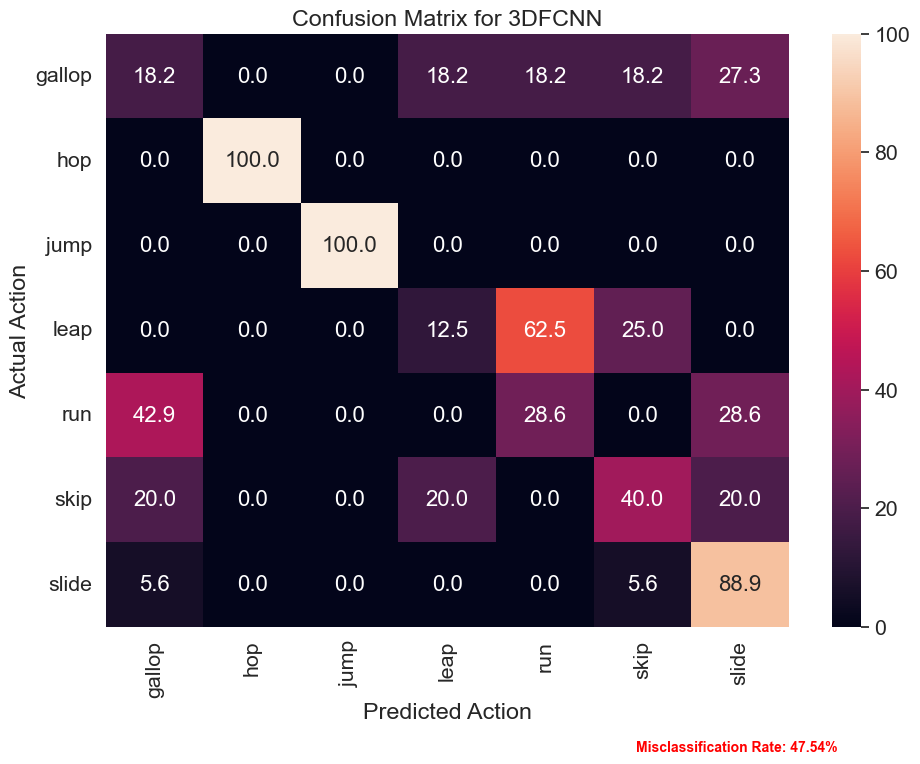

In [17]:
model = tf.keras.models.load_model("../../models/3DFCNN.h5")

y_pred = model.predict(X_test)

plot_confusion_matrix(y_test, y_pred, labels=CLASSES_LIST, ds_type="3DFCNN")

In [18]:
import os 

model_size = os.path.getsize("../../models/3DFCNN.h5") / 1000000

print(f"3DFCNN Model Size: {model_size} MB")

3DFCNN Model Size: 5.352136 MB


In [19]:
def get_flops(model_h5_path):
    session = tf.compat.v1.Session()
    graph = tf.compat.v1.get_default_graph()


    with graph.as_default():
        with session.as_default():
            model = tf.keras.models.load_model(model_h5_path)

            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

            # We use the Keras session graph in the call to the profiler.
            flops = tf.compat.v1.profiler.profile(graph=graph,
                                                  run_meta=run_meta, cmd='op', options=opts)

            return flops.total_float_ops

In [20]:
print(f"Total flops for 3D FCNN Model: {get_flops('../../models/3DFCNN.h5')/10**6} MFLOPS")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Total flops for 3D FCNN Model: 0.4347 MFLOPS


Run inference

In [2]:
from moviepy.editor import VideoFileClip
import tempfile
import torch
from preprocessing.pose_keypoint import pose_inference_with_align
import cv2
from pathlib import Path
from constants import globals as g
from mmaction.apis import (
    detection_inference,
)
from utils import settings
from mmaction.utils import frame_extract

%load_ext autoreload
%autoreload 2

tmp_dir = tempfile.TemporaryDirectory()

def clipped_one_sec(video_path) -> str:
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Could not open: {video_path}")

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    duration = total_frames / fps

    start_time = (duration / 2) - 0.5
    start_frame = int(start_time * fps)

    frames = []
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    for _ in range(fps):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()

    clip_path = f"{tmp_dir.name}/1-sec-clip.mp4"
    out = cv2.VideoWriter(
        clip_path,
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (
            frames[0].shape[1],
            frames[0].shape[0],
        ),
    )

    for frame in frames:
        out.write(frame)

    out.release()
    return clip_path

def center_crop(input_path, aspect_ratio=(4, 3)):
    video = VideoFileClip(str(input_path))

    original_width, original_height = video.size

    target_width, target_height = aspect_ratio
    new_height = original_width * target_height / target_width

    if new_height > original_height:
        new_height = original_height
        new_width = new_height * target_width / target_height
    else:
        new_width = original_width

    x_center = original_width / 2
    y_center = original_height / 2
    crop_x1 = x_center - new_width / 2
    crop_x2 = x_center + new_width / 2
    crop_y1 = y_center - new_height / 2
    crop_y2 = y_center + new_height / 2

    cropped_video = video.crop(x1=crop_x1, y1=crop_y1, x2=crop_x2, y2=crop_y2)

    with tempfile.NamedTemporaryFile(delete=False, suffix='.mp4') as temp_file:
        temp_file_path = temp_file.name
    
    cropped_video.write_videofile(temp_file_path)

    return temp_file_path


if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

filename = "hop-trial.mp4"
src_vid = Path(g.TEST_DATA_DIR, filename)
src_cropped = center_crop(src_vid)
src_clipped_vid = clipped_one_sec(src_cropped)

frame_paths, frames = frame_extract(
    src_clipped_vid,
    out_dir=tmp_dir.name,
    short_side=1080
)

torch.cuda.empty_cache()
det_results, _ = detection_inference(
    det_config=settings.det_config,
    det_checkpoint=settings.det_checkpoint,
    det_score_thr=settings.det_score_thr,
    frame_paths=frame_paths,
    device=device,
    with_score=True
)
keypoints, scores = pose_inference_with_align(frame_paths, det_results)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Moviepy - Building video C:\Users\nepom\AppData\Local\Temp\tmpsu3jwzbj.mp4.
Moviepy - Writing video C:\Users\nepom\AppData\Local\Temp\tmpsu3jwzbj.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\nepom\AppData\Local\Temp\tmpsu3jwzbj.mp4
Loads checkpoint by local backend from path: C:\Users\nepom\Downloads\gm-activity-recognition\models\faster_rcnn_r50_fpn_1x_coco-person_20201216_175929-d022e227.pth
Performing Human Detection for each frame
[                                                  ] 0/30, elapsed: 0s, ETA:06/18 02:05:49 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
06/18 02:05:49 - mmengine - WARNING - "HardDiskBackend" is the alias of "LocalBackend" and the former will be deprecated in future.
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 11.5 task/s, elapsed: 3s, ETA:     0s
Loads checkpoint by local backend from path: C:\Users\nepom\Downloads\gm-activity-recognition\models\hrnet_w32_coco_256x192-c78dce93_20200708.pth
Performing Human Pose Estimation for each frame
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 7.3 t

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import io
import tempfile
from scipy.ndimage import gaussian_filter
from PIL import Image
import imageio
from pathlib import Path

def create_heatmap_gif(keypoints, target_frames):
    frames = []

    for frame_index in range(len(target_frames)):
        heatmap = np.zeros(target_frames[frame_index].shape[:2])
        spread = 10

        for joint in keypoints[frame_index]:
            x, y = int(joint[0]), int(joint[1])
            if 0 <= x < heatmap.shape[1] and 0 <= y < heatmap.shape[0]:
                heatmap[y, x] = 1

        heatmap_blurred = gaussian_filter(heatmap, sigma=spread)
        heatmap_normalized = heatmap_blurred / heatmap_blurred.max()

        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(heatmap_normalized, interpolation="nearest")
        ax.axis("off")

        # Save the frame to a buffer
        buf = io.BytesIO()
        plt.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
        buf.seek(0)
        plt.close(fig)

        # Resize the image to 224x224
        image = Image.open(buf)
        image = image.resize((224, 224), Image.Resampling.LANCZOS)
        frames.append(np.array(image))

    # Create a temporary file to save the GIF
    with tempfile.NamedTemporaryFile(delete=False, suffix=".gif") as temp_file:
        temp_file_path = temp_file.name

    # Save the frames as a GIF in the temporary file
    imageio.mimsave(temp_file_path, frames, duration=1)

    return temp_file_path

In [14]:
import os
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [5]:
input_src = create_heatmap_gif(keypoints[1, :], frames)

In [12]:
input_arr = frames_from_video_file(input_src)

In [4]:
input_arr = np.expand_dims(input_arr, 0)

In [5]:
input_arr.shape

(1, 10, 128, 128, 3)

In [6]:
model = tf.keras.models.load_model("../../models/3DFCNN.h5")

In [8]:
import time

In [60]:
start = time.time()
result = model.predict(input_arr)
end = time.time()

CLASSES_LIST = ['gallop', 'hop', 'jump', 'leap', 'run', 'skip', 'slide']

label, score = CLASSES_LIST[np.argmax(result)], np.max(result)
elapsed = end - start
print(f"Elapsed inference time: {round(elapsed, 4)} seconds")

print(
    f"Predicted action: {label.upper()} with confidence score of {round((score*100), 4)}%."
)

1/1 [==============================] - 0s 85ms/step
Elapsed inference time: 0.1105 seconds
Predicted action: LEAP with confidence score of 91.0402%.
